# Numerical simulation of the output distribution of a Mach-Zehnder interferometer with imperfect single-photon sources

@Author: Mathias Pont (mathias.pont@c2n.upsaclay.fr)<br>
@Affiliation:<br>
Centre for Nanosciences and Nanotechnology, CNRS, Universite Paris-Saclay, UMR 9001,<br>
10 Boulevard Thomas Gobert,<br>
91120 Palaiseau, France<br>

This Jupyter notebook simulate two-photon interference with an imperfect single-photon source using the linear optical circuit development framework Perceval. This work mainly focus on the effect of multi-photon terms and partial distinguishability on the output distribution of a Mach-Zehnder interferometer (MZI).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.collections import PolyCollection
plt.rcParams['figure.figsize'] = (16,8)

In [2]:
import perceval as pcvl
import perceval.lib.symb as symb

In [3]:
class QPU:

    def __init__(self):
        # Set up Perceval
        self.simulator_backend = pcvl.BackendFactory().get_backend('Naive')

        # MZI interferometer
        self.mzi_circuit = pcvl.Circuit(m=2, name="MZI")

        self.phase_shifters = [pcvl.Parameter("phi1"), pcvl.Parameter("phi2")]

        (self.mzi_circuit
         .add(0, symb.PS(self.phase_shifters[0]))
         .add((0, 1), symb.BS())
         .add(0, symb.PS(self.phase_shifters[1]))
         .add((0, 1), symb.BS())
         )

        # Initial phase set to zero
        self.phase_shifters[0].set_value(0)
        # Internal phase set to pi/2
        self.phase_shifters[1].set_value(np.pi / 2)

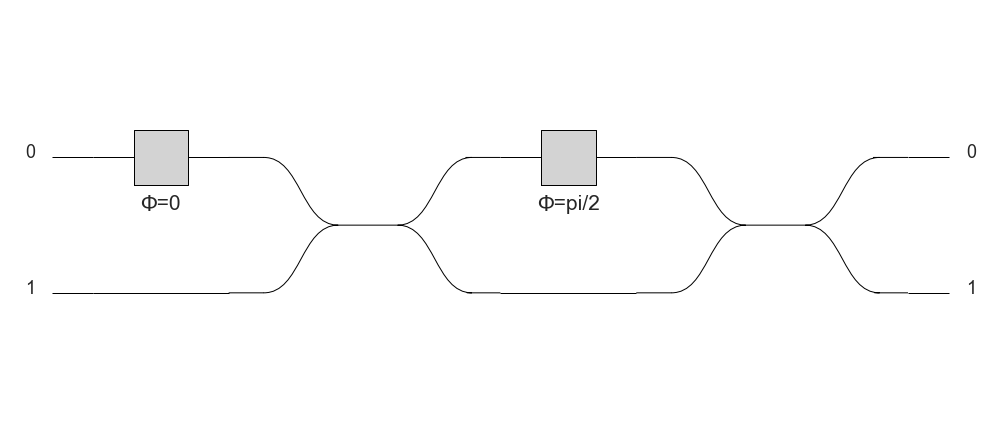

In [4]:
qpu = QPU()
# Display the interferometer
qpu.mzi_circuit.pdisplay(output_format="mplot")

In [5]:
# mzi_BasicState computes the output state distribution of any input Fock state.
def mzi_BasicState(input_state):
    """
    :param input_state: '|1,1>'
    :return: plots the output states probability as a function of the internal phase of the MZI
    """
    
    qpu = QPU()
    
    scan_range = np.arange(0, 2*np.pi, 0.1)

    outcome_theta = {}
    outcome = []

    for theta in scan_range:

        output_prob = dict()

        qpu.phase_shifters[1].set_value(theta)
        sim = qpu.simulator_backend(qpu.mzi_circuit.U)

        for output_state, probability in sim.allstateprob_iterator(pcvl.BasicState(input_state)):

            output_state = str(output_state)

            if output_state not in outcome:
                outcome.append(output_state)

            if output_state in output_prob:
                output_prob[output_state] += probability
            else:
                output_prob[output_state] = probability

        outcome_theta[theta] = output_prob

    # 2D plot
    fig, ax = plt.subplots()
    for measured_state in outcome:
        ax.plot(outcome_theta.keys(),
                 [outcome_theta[angle][measured_state] for angle in outcome_theta.keys()],
                 '-s',
                 label=measured_state,
                 alpha=0.9)
    ax.set_ylabel('Probability', fontsize=24)
    ax.set_xlabel('Internal phase of the MZI [rad]', fontsize=24)
    ax.legend(fontsize=18)
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=16)

    # 3D plot     
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    xs = scan_range
    verts = []
    ys = np.linspace(0, 1, len(outcome))
    facecolors = sns.color_palette()
    for measured_state in outcome:
        verts.append(list(zip(xs, [outcome_theta[angle][measured_state] for angle in outcome_theta.keys()])))
    poly = PolyCollection(verts, facecolors=facecolors)
    for i, measured_state in enumerate(outcome):
        ax.scatter(scan_range,
                   ys[i],
                   [outcome_theta[angle][measured_state] for angle in outcome_theta.keys()],
                   color=facecolors[i])
        
    ax.set_xlim3d(0, 2*np.pi)
    plt.xticks([0, np.pi / 2, np.pi, 3*np.pi/2, 2*np.pi],
               [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'],
               fontsize=18)
    
    ax.set_ylim3d(-0.1, 1.1)
    plt.yticks(ys, outcome, fontsize=20, ha='left')
    
    ax.set_zlim3d(0, 1)
    
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=20)
    
    
    
    return None

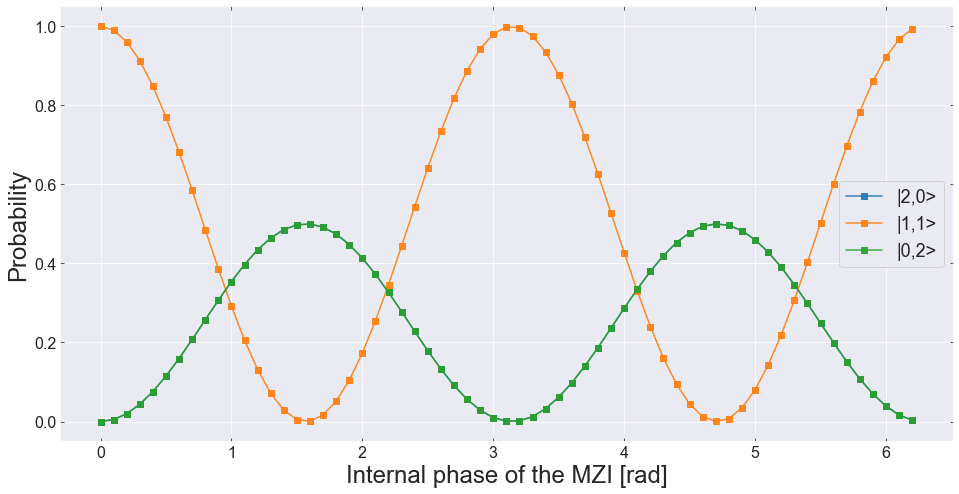

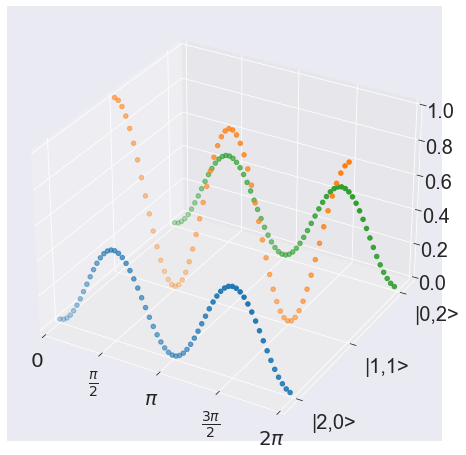

In [6]:
# Computes all the output states probabilities for a given input ket
mzi_BasicState('|1,1>')

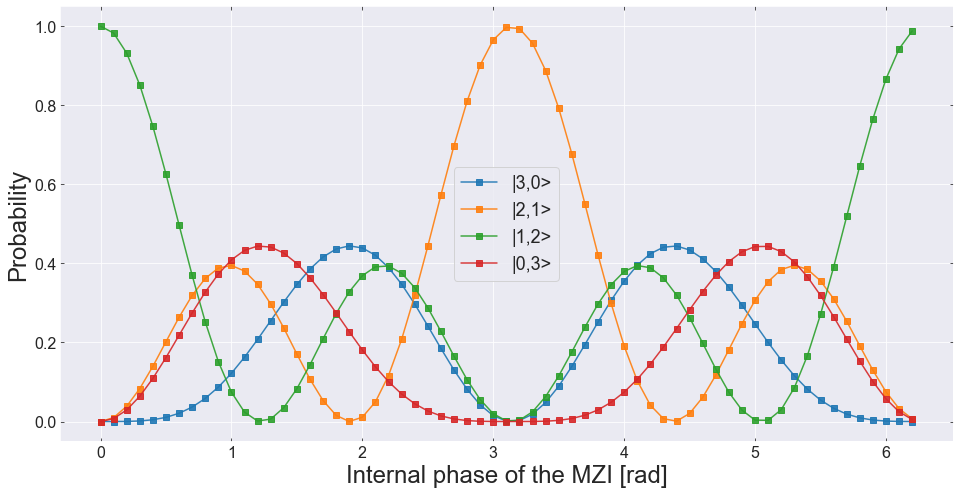

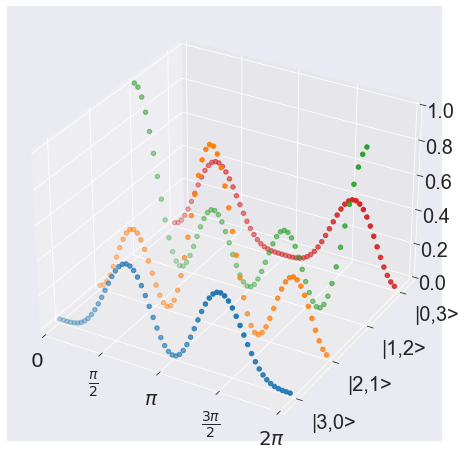

In [7]:
# Computes all the output states probabilities for a given input ket
mzi_BasicState('|2,1>')

# AnySource

mzi_Anysource computes the output state distribution of any input Forck state with click detectors.

In [8]:
def outputstate_to_2outcome(output):
    """
    :param output: an output of the chip
    :return: a measurable outcome
    """
    state = []
    for m in output:
        if m.isdigit():
            state.append(m)

    if int(state[0]) == 0 and int(state[1]) == 0:
        return '|0,0>', 0
    if int(state[0]) == 0 and int(state[1]) > 0:
        return '|0,1>', int(state[1])
    if int(state[0]) > 0 and int(state[1]) == 0:
        return '|1,0>', int(state[0])
    if int(state[0]) > 0 and int(state[1]) > 0:
        return '|1,1>', (int(state[0]) + int(state[1]))/2

In [9]:
def mzi_AnySource(input_states_dict):
    
    """
    :param input_states_dict: {'|1,1>':1}
    :return: visibility of the 2-photon interference fringe
    :plot: probability of each outcome as a function of the internal phase of the MZI
    """
    
    qpu = QPU()


    scan_range = np.arange(0, np.pi, 0.1)

    plot_outcome = {'|1,0>':[], '|1,1>':[], '|0,1>':[]}
    

    for theta in scan_range:

        outcome = {'|1,0>': 0,
                   '|1,1>': 0,
                   '|0,1>': 0
                  }

        qpu.phase_shifters[1].set_value(theta)
        
        sim = qpu.simulator_backend(qpu.mzi_circuit.U)

        for input_n in input_states_dict:
            for output_state, probability in sim.allstateprob_iterator(pcvl.BasicState(input_n)):
                result, N = outputstate_to_2outcome(str(output_state))
                outcome[result] += input_states_dict[input_n] * probability

        plot_outcome['|1,0>'].append(outcome['|1,0>'])
        plot_outcome['|1,1>'].append(outcome['|1,1>'])
        plot_outcome['|0,1>'].append(outcome['|0,1>'])

    plt.figure()
    for out in plot_outcome:
        plt.plot(scan_range, plot_outcome[out], '-o', label=out)
    plt.xlabel('Phase [rad]', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.grid()
    plt.legend()

    # Compute this ouput distribution for phi2=pi/2

    outcome = {'|1,0>': 0,
               '|1,1>': 0,
               '|0,1>': 0
              }

    qpu.phase_shifters[1].set_value(np.pi / 2)
    sim = qpu.simulator_backend(qpu.mzi_circuit.U)

    for input_n in input_states_dict:

        for output_state, probability in sim.allstateprob_iterator(pcvl.BasicState(input_n)):
            result, N = outputstate_to_2outcome(str(output_state))
            outcome[result] += input_states_dict[input_n] * probability

    p_corr = outcome['|1,1>']
    
    # Compute this ouput distribution for phi2=0

    outcome = {'|1,0>': 0,
               '|1,1>': 0,
               '|0,1>': 0
              }

    qpu.phase_shifters[1].set_value(0)
    sim = qpu.simulator_backend(qpu.mzi_circuit.U)

    for input_n in input_states_dict:

        for output_state, probability in sim.allstateprob_iterator(pcvl.BasicState(input_n)):
            result, N = outputstate_to_2outcome(str(output_state))
            outcome[result] += input_states_dict[input_n] * probability

    p_uncorr = outcome['|1,1>']

    return 1-2*p_corr/p_uncorr


1.0

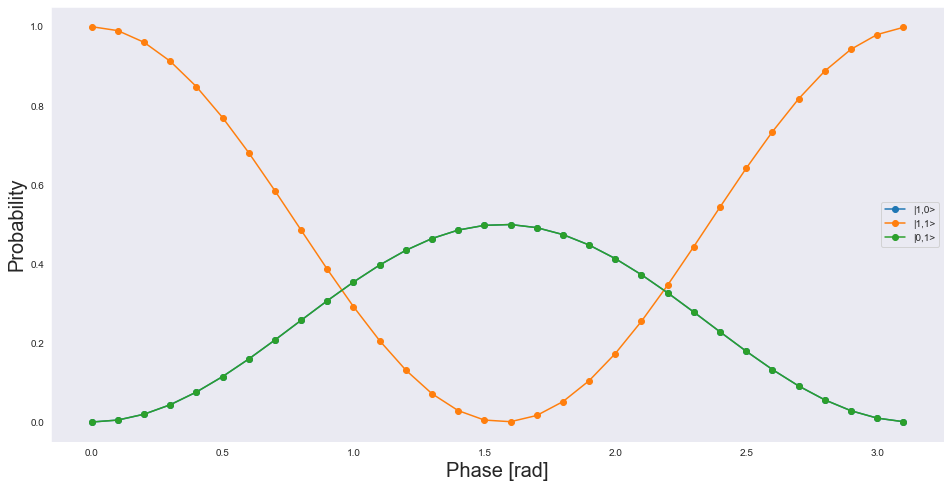

In [10]:
# Computes all visibility of the 2-photon fringe interference for a given dict of weighted input states
mzi_AnySource({'|1,1>':1})

# Imperfect Source

Here we suppose that we only have access to click detectors. All the outputs of the chip will be either a single click on one of the detector or a double click. We compute the probability of each of these outcomes. In what follows we 

In [11]:
def compute(qpu, beta, eta, g2, M, multiphoton_model="distinguishable"):
    # Find out all the input states that must be considered depending on the characteristics of the source
    sps = pcvl.Source(emission_prob=beta,
                      overall_transmission=eta,
                      multiphoton_component=g2,
                      multiphoton_model=multiphoton_model,
                      indistinguishability=M,
                      indistinguishability_model="homv"
                     )

    outcome = {'|0,0>': 0,
               '|1,0>': 0,
               '|1,1>': 0,
               '|0,1>': 0
               }

    qpu.phase_shifters[1].set_value(np.pi)
    p = pcvl.Processor({0: sps, 1: sps, }, qpu.mzi_circuit)

    all_p, sv_out = p.run(qpu.simulator_backend)
    for output_state in sv_out:
        # print(str(output_state), str(sv_out[output_state]))
        # Each output is mapped to an outcome
        result, N = outputstate_to_2outcome(str(output_state))
        # The probability of an outcome is added, weighted by the probability of this input
        outcome[result] += sv_out[output_state]

    p_uncorr = outcome['|1,1>']

    outcome = {'|0,0>': 0,
               '|1,0>': 0,
               '|1,1>': 0,
               '|0,1>': 0
               }

    qpu.phase_shifters[1].set_value(np.pi / 2)
    p = pcvl.Processor({0: sps, 1: sps, }, qpu.mzi_circuit)

    all_p, sv_out = p.run(qpu.simulator_backend)
    for output_state in sv_out:
        # print(str(output_state), str(sv_out[output_state]))
        # Each output is mapped to an outcome
        result, N = outputstate_to_2outcome(str(output_state))
        # The probability of an outcome is added, weighted by the probability of this input
        outcome[result] += sv_out[output_state]

    p_corr = outcome['|1,1>']



    return 1 - 2 * p_corr / p_uncorr

In [12]:
# Computes all visibility of the 2-photon fringe interference for an imperfect single-photon source
compute(QPU(), beta=1, eta=1, g2=0.02, M=0.95)

0.9301507392172729

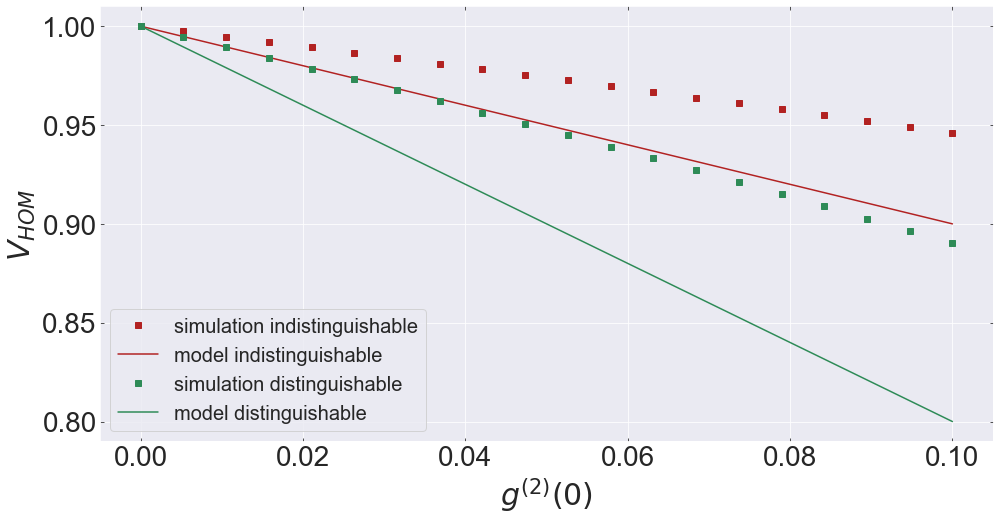

In [19]:
qpunit = QPU()

beta = 1
eta = 1
M=1
Nb = 20
X = np.array(np.linspace(0.0, 0.1, Nb))
Y = np.array(np.linspace(0.8, 1, Nb))

# V_HOM vs g2
z11 = [compute(qpunit, beta, eta, g2, M, multiphoton_model="indistinguishable") for g2 in X]
z12 = [compute(qpunit, beta, eta, g2, M, multiphoton_model="distinguishable") for g2 in X]

z1_th1 = [M - g2 for g2 in X]
z1_th2 = [M - (1 + M) * g2 for g2 in X]


# Plot V_HOM vs g2
plt.figure()
plt.plot(X, z11, 's', label='simulation indistinguishable', color='firebrick')
plt.plot(X, z1_th1, label='model indistinguishable', color='firebrick')
plt.plot(X, z12, 's', label='simulation distinguishable', color='seagreen')
plt.plot(X, z1_th2, label='model distinguishable', color='seagreen')
plt.grid(True)
plt.legend(fontsize=20)
plt.xlabel(r'$g^{(2)}(0)$', fontsize=30)
plt.ylabel(r'$V_{HOM}$', fontsize=30)
plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=28)

ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

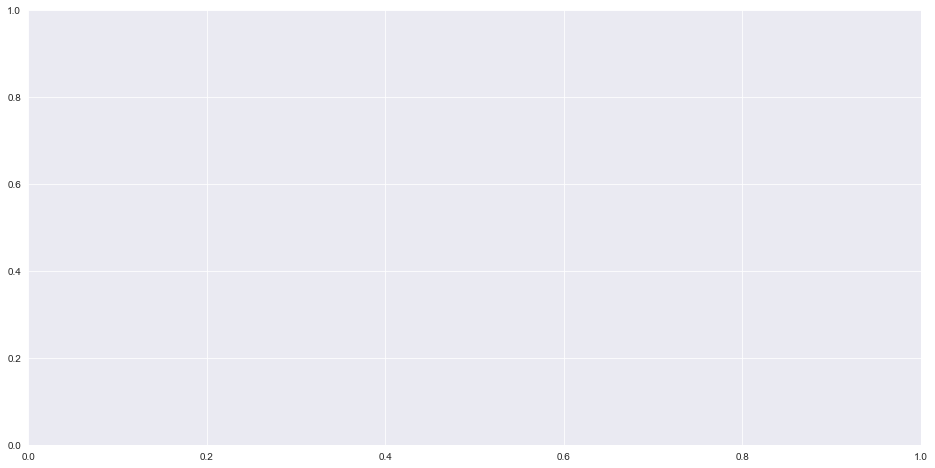

In [26]:
qpunit = QPU()

beta = 1
eta = 0.23
M=1
Nb = 20

X = np.array(np.linspace(0.0, 0.1, Nb)) # g2
Y = np.array(np.linspace(0.01, 1, Nb)) # beta

z11 = [compute(qpunit, beta, eta, g2, M, multiphoton_model="indistinguishable") for g2 in X]
z12 = [compute(qpunit, beta, eta, g2, M, multiphoton_model="distinguishable") for g2 in X]

fig, ax = plt.subplots()

for beta in Y:
    ax.plot(beta, [compute(qpunit, beta, eta, beta, M, multiphoton_model="distinguishable") for g2 in X])

ax.plot(X, z11, 's', label='simulation indistinguishable', color='firebrick')
ax.plot(X, z12, 's', label='simulation distinguishable', color='seagreen')
ax.set_xlabel(r'$g^{(2)}(0)$', fontsize=30)
ax.set_ylabel('Occupation probability', fontsize=30)
cb.set_label(label=r'$p_2$',size=30)
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=16)

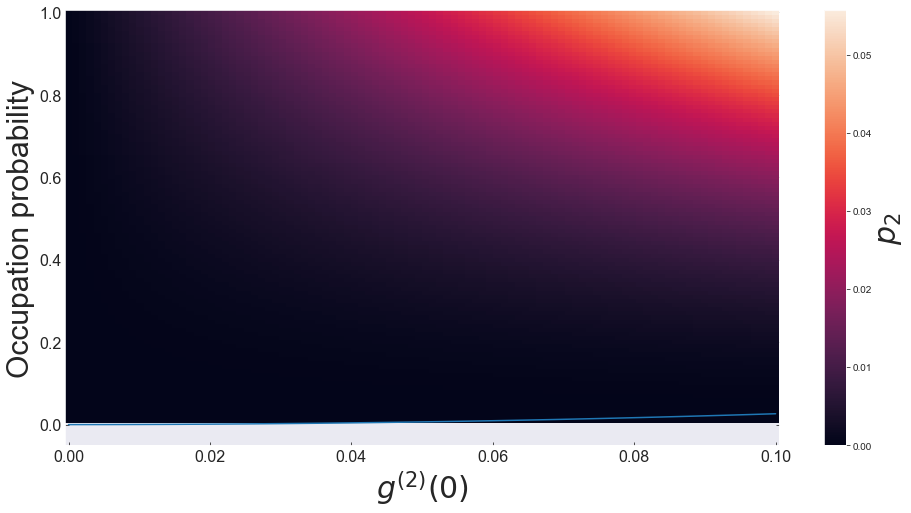

In [19]:
Nb = 100
X = np.array(np.linspace(0.0, 0.1, Nb)) # g2
Y = Y = np.array(np.linspace(0.01, 1, Nb)) # beta

p2 = np.array([[min(np.poly1d([g2, -2 * (1 - g2 * beta), g2 * beta ** 2]).r) for g2 in X] for beta in Y])
p1 = np.array([[beta-min(np.poly1d([g2, -2 * (1 - g2 * beta), g2 * beta ** 2]).r) for g2 in X] for beta in Y])

fig, ax = plt.subplots()
cf = ax.pcolormesh(X, Y, p2, shading='auto')
ax.plot(X, [min(np.poly1d([0.05, -2 * (1 - 0.05 * beta), 0.05 * beta ** 2]).r) for beta in Y])
ax.set_xlabel(r'$g^{(2)}(0)$', fontsize=30)
ax.set_ylabel('Occupation probability', fontsize=30)
cb = fig.colorbar(cf)
cb.set_label(label=r'$p_2$',size=30)
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=16)

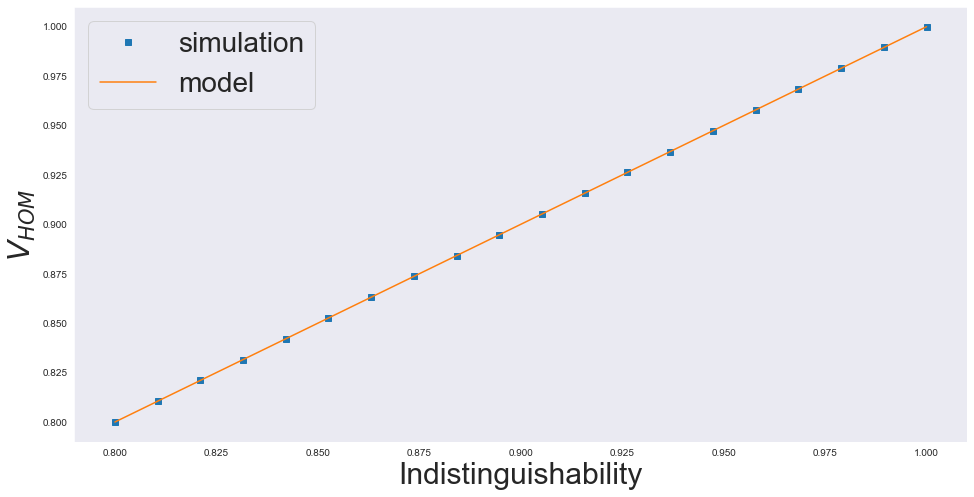

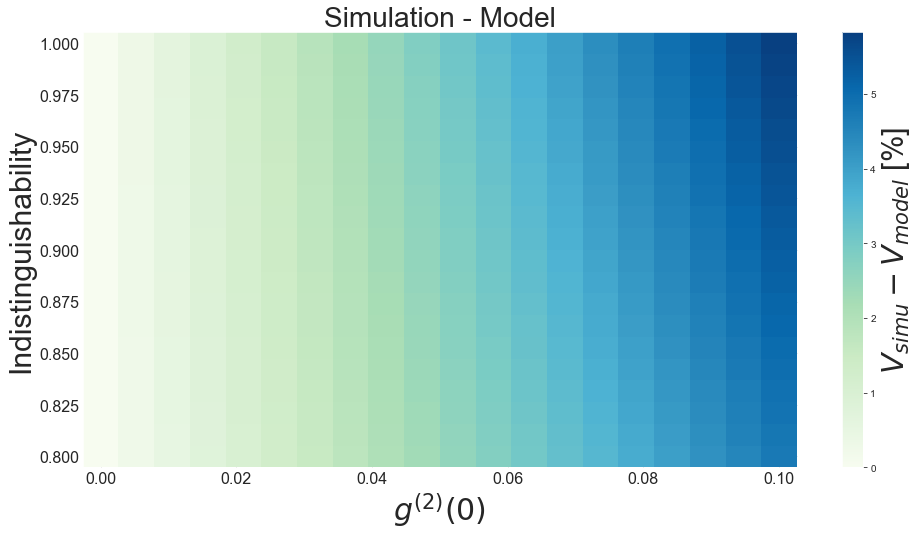

In [22]:
# V_HOM vs M
z2 = [compute(qpunit, beta, eta, 0, m) for m in Y]

# V_HOM vs M
fig, ax = plt.subplots()
ax.plot(Y, z2, 's', label='simulation')
ax.plot(Y, Y, label='model')
ax.grid()
ax.legend(fontsize=28)
ax.set_xlabel('Indistinguishability', fontsize=30)
ax.set_ylabel(r'$V_{HOM}$', fontsize=30)


# V_HOM vs g2 & M
Z = np.array([[compute(qpunit, beta, eta, g2, M) for g2 in X] for M in Y])

Z_th = np.array([[M * (1 - g2) - g2 for g2 in X] for M in Y])

# V_HOM vs g2 & M
fig, ax = plt.subplots()
cf = ax.pcolormesh(X, Y, (Z - Z_th) * 100, shading='auto', cmap='GnBu')
ax.set_title('Simulation - Model', fontsize=28)
ax.set_xlabel(r'$g^{(2)}(0)$', fontsize=30)
ax.set_ylabel('Indistinguishability', fontsize=30)
cb = fig.colorbar(cf)
cb.set_label(label=r'$V_{simu}-V_{model}$ [%]',size=30)
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=16)